In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

if "workding_dir" not in locals():
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        workding_dir = "/content/drive/MyDrive/logical-reasoning/"
    except ModuleNotFoundError:
        workding_dir = str(Path.cwd().parent)

In [3]:
import os
import sys

os.chdir(workding_dir)
sys.path.append(workding_dir)
print("workding dir:", workding_dir)

workding dir: d:\code\projects\logical-reasoning


In [4]:
from dotenv import find_dotenv, load_dotenv

found_dotenv = find_dotenv(".env")

if len(found_dotenv) == 0:
    found_dotenv = find_dotenv(".env.example")
print(f"loading env vars from: {found_dotenv}")
load_dotenv(found_dotenv, override=True)

loading env vars from: d:\code\projects\logical-reasoning\.env


True

In [5]:
import os

model_name = os.getenv("MODEL_NAME")
data_path = os.getenv("LOGICAL_REASONING_DATA_PATH")
results_path = os.getenv("LOGICAL_REASONING_RESULTS_PATH")
max_new_tokens = int(os.getenv("MAX_NEW_TOKENS", 2048))

print(model_name, data_path, results_path, max_new_tokens)

claude-3-5-sonnet-20240620 datasets/mgtv data/anthropic_results.csv 16


In [6]:
from llm_toolkit.llm_utils import *
from llm_toolkit.logical_reasoning_utils import *

loading d:\code\projects\logical-reasoning\llm_toolkit\logical_reasoning_utils.py


In [7]:
datasets = load_logical_reasoning_dataset(data_path)

prompt = get_few_shot_prompt_template(10, datasets["train"].to_pandas(), debug=True)

loading train/test data files
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'answer', 'title', 'puzzle', 'truth'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'answer', 'title', 'puzzle', 'truth'],
        num_rows: 3000
    })
})
num_shots: 10
labels: ['不是' '不重要' '是' '问法错误' '回答正确']
P2_few_shot: 你是一个情景猜谜游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。
2. 主持人知道谜底，谜底是谜面的答案。
3. 参与者可以询问任何封闭式问题来找寻事件的真相。
4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判断标准如下：
   - 若谜面和谜底能找到问题的答案，回答：是或者不是
   - 若谜面和谜底不能直接或者间接推断出问题的答案，回答：不重要
   - 若参与者提问不是一个封闭式问题或者问题难以理解，回答：问法错误
   - 若参与者提问基本还原了谜底真相，回答：回答正确
5. 回答中不能添加任何其它信息，也不能省略选项中的任何一个字。例如，不可以把“不是”省略成“不”。

请严格按照这些规则回答参与者提出的问题。

示例输入和输出: 
谜面: 在甄家村里，有一个古老的传说：每年南瓜丰收的季节，南瓜田里总有一个最大的南瓜会不翼而飞，村民们对此现象困惑不解。请找出南瓜失踪背后的原因。
谜底: 真相原来与一位年迈的农夫有关。这位农夫年轻时，曾与一位美丽的姑娘相恋。他们约定在南瓜丰收的季节结婚。然而，命运弄人，姑娘在婚礼前的一场意外中离世。悲伤的农夫为了纪念心爱的姑娘，每年都会将最大的南瓜偷走，放到姑娘的墓前，以此寄托自己的哀思。这一行为延续了多年，成为了乡村里一个神秘的传说。
参与者提出的问题: 偷的人信神吗
回答: 不是

谜面: 在甄家

In [8]:
row = datasets["test"][0]
row

{'text': '甄加索是自杀吗',
 'label': '不是',
 'answer': None,
 'title': '海岸之谜',
 'puzzle': '在远离城市喧嚣的海边小屋，一天清晨，邻居发现甄加索僵卧在沙滩上，已无生命迹象。现场没有发现任何打斗的迹象。请问甄加索的死因是什么？',
 'truth': '甄加索是一位热爱自然的画家，他每年都会来到这个海边小屋寻找灵感。在他生命的最后几天，他一直在创作一幅描绘海洋生物的画作。在画即将完成的前一天晚上，他骑着自行车外出，打算在海边观赏夜景。然而，他在沙滩上意外发现了一只搁浅的海豚，为了救助这只海豚，他耗费了极大的体力，最终成功将其送回海中。筋疲力尽的甄加索在沙滩上睡着了，由于他患有严重的心脏病，却未告知旁人，在寒冷的海风中，他的心脏停止了跳动。因此，警方在现场只发现了车轮痕迹和未完成的画作，而没有发现任何他杀的迹象。'}

In [9]:
user_prompt = prompt.format(row["puzzle"], row["truth"], row["text"])

In [10]:
%%time

invoke_langchain(user_prompt, max_tokens=max_new_tokens, model=model_name, is_openai=False)

CPU times: total: 46.9 ms
Wall time: 2.72 s


'不是'

## Run Completion Endpoints

In [13]:
from llm_toolkit.eval_openai import evaluate_model_with_num_shots

In [15]:
%%time

evaluate_model_with_num_shots(
    model_name,
    datasets,
    results_path=results_path,
    range_num_shots=[0, 10],
    max_new_tokens=max_new_tokens,
)

Evaluating model: claude-3-5-sonnet-20240620
--------------------------------------------------
text: 甄加索是自杀吗
--------------------------------------------------
label: 不是
--------------------------------------------------
answer: nan
--------------------------------------------------
title: 海岸之谜
--------------------------------------------------
puzzle: 在远离城市喧嚣的海边小屋，一天清晨，邻居发现甄加索僵卧在沙滩上，已无生命迹象。现场没有发现任何打斗的迹象。请问甄加索的死因是什么？
--------------------------------------------------
truth: 甄加索是一位热爱自然的画家，他每年都会来到这个海边小屋寻找灵感。在他生命的最后几天，他一直在创作一幅描绘海洋生物的画作。在画即将完成的前一天晚上，他骑着自行车外出，打算在海边观赏夜景。然而，他在沙滩上意外发现了一只搁浅的海豚，为了救助这只海豚，他耗费了极大的体力，最终成功将其送回海中。筋疲力尽的甄加索在沙滩上睡着了，由于他患有严重的心脏病，却未告知旁人，在寒冷的海风中，他的心脏停止了跳动。因此，警方在现场只发现了车轮痕迹和未完成的画作，而没有发现任何他杀的迹象。
*** Evaluating with num_shots: 0
user_prompt: 你是一个情景猜谜游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。
2. 主持人知道谜底，谜底是谜面的答案。
3. 参与者可以询问任何封闭式问题来找寻事件的真相。
4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回答的判断标准如下：
   - 若谜面和谜底能找到问题的答案，回答：是或者不是
   - 若谜面和谜底不能直接或者间接推断出问题的答案，回答：不重要
   - 若参与者

100%|██████████| 3000/3000 [1:21:20<00:00,  1.63s/it]


claude-3-5-sonnet-20240620/shots-00 metrics: {'accuracy': 0.698, 'incorrect_ids': [9, 10, 11, 12, 17, 21, 23, 24, 29, 31, 34, 35, 36, 42, 52, 55, 58, 59, 62, 64, 65, 66, 67, 77, 81, 82, 84, 88, 91, 93, 94, 97, 101, 102, 104, 105, 109, 112, 113, 115, 116, 117, 124, 129, 131, 139, 143, 150, 155, 161, 163, 164, 173, 179, 189, 191, 192, 193, 198, 200, 201, 202, 207, 215, 220, 221, 222, 224, 225, 228, 229, 230, 231, 235, 236, 237, 240, 245, 248, 249, 250, 251, 252, 253, 255, 257, 259, 260, 261, 263, 268, 269, 271, 273, 283, 284, 286, 289, 290, 292, 293, 295, 299, 301, 303, 304, 308, 309, 311, 314, 317, 318, 320, 321, 323, 326, 328, 329, 330, 333, 334, 335, 337, 338, 350, 355, 356, 357, 360, 362, 363, 364, 368, 370, 371, 372, 373, 374, 377, 383, 389, 395, 396, 397, 408, 410, 414, 421, 426, 430, 440, 447, 451, 452, 454, 456, 458, 461, 464, 465, 466, 467, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 482, 483, 484, 485, 486, 487, 488, 490, 492, 493, 494, 496, 497, 500, 501, 502, 503, 506, 

  2%|▏         | 72/3000 [02:42<1:50:20,  2.26s/it]


RateLimitError: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'Number of request tokens has exceeded your daily rate limit (https://docs.anthropic.com/en/api/rate-limits); see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}

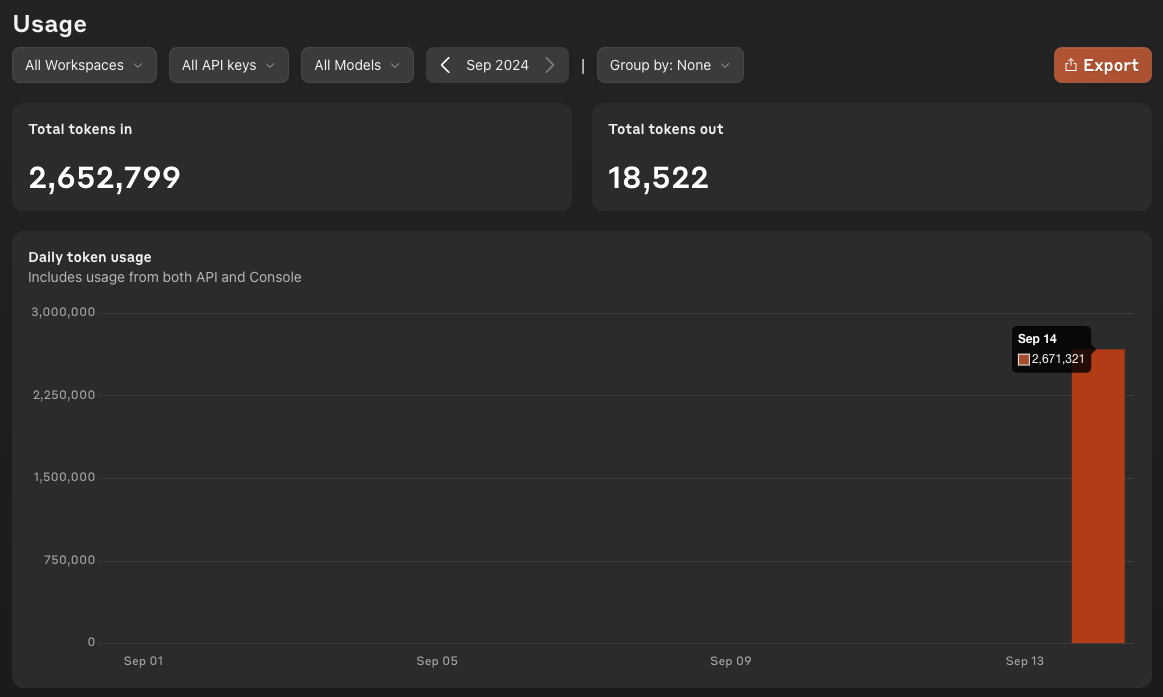

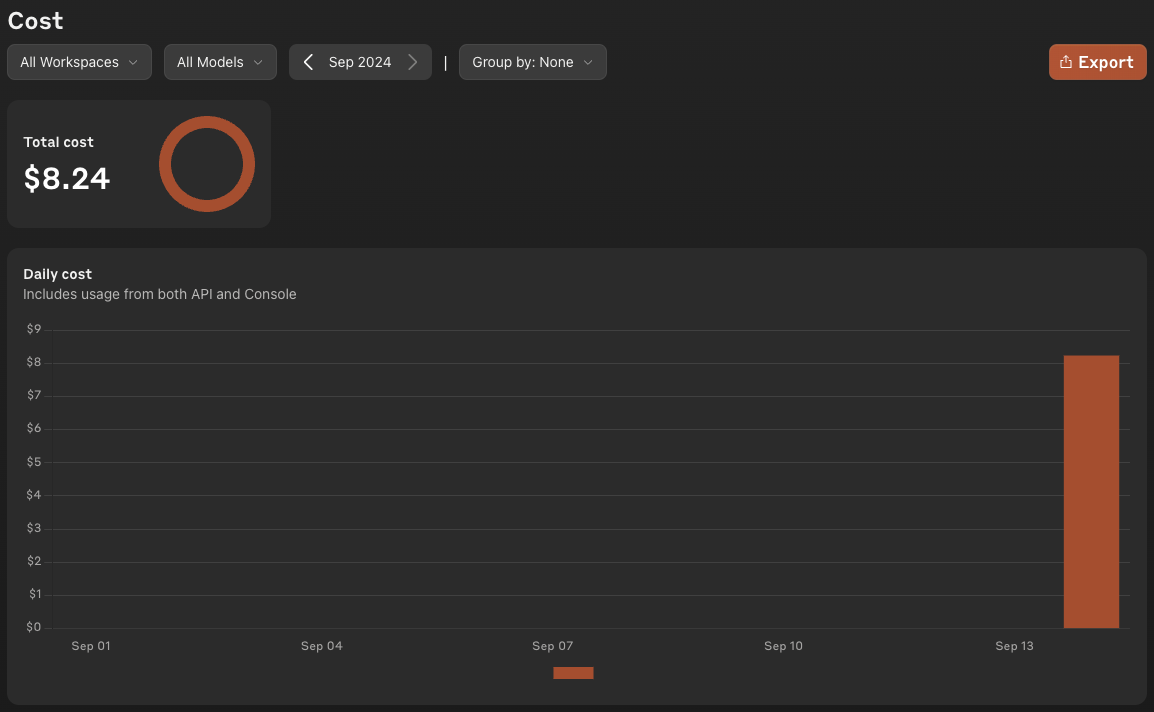

In [17]:
%%time

evaluate_model_with_num_shots(
    model_name,
    datasets,
    results_path=results_path,
    range_num_shots=[10],
    max_new_tokens=max_new_tokens,
)

loading d:\code\projects\logical-reasoning\llm_toolkit\logical_reasoning_utils.py
Evaluating model: claude-3-5-sonnet-20240620
--------------------------------------------------
text: 甄加索是自杀吗
--------------------------------------------------
label: 不是
--------------------------------------------------
answer: nan
--------------------------------------------------
title: 海岸之谜
--------------------------------------------------
puzzle: 在远离城市喧嚣的海边小屋，一天清晨，邻居发现甄加索僵卧在沙滩上，已无生命迹象。现场没有发现任何打斗的迹象。请问甄加索的死因是什么？
--------------------------------------------------
truth: 甄加索是一位热爱自然的画家，他每年都会来到这个海边小屋寻找灵感。在他生命的最后几天，他一直在创作一幅描绘海洋生物的画作。在画即将完成的前一天晚上，他骑着自行车外出，打算在海边观赏夜景。然而，他在沙滩上意外发现了一只搁浅的海豚，为了救助这只海豚，他耗费了极大的体力，最终成功将其送回海中。筋疲力尽的甄加索在沙滩上睡着了，由于他患有严重的心脏病，却未告知旁人，在寒冷的海风中，他的心脏停止了跳动。因此，警方在现场只发现了车轮痕迹和未完成的画作，而没有发现任何他杀的迹象。
*** Evaluating with num_shots: 10
user_prompt: 你是一个情景猜谜游戏的主持人。游戏规则如下：

1. 参与者会得到一个谜面，谜面会描述一个简单又难以理解的事件。
2. 主持人知道谜底，谜底是谜面的答案。
3. 参与者可以询问任何封闭式问题来找寻事件的真相。
4. 对于每个问题，主持人将根据实际情况回答以下五个选项之一：是、不是、不重要、回答正确、问法错误。各回

 10%|▉         | 285/3000 [16:49<2:40:19,  3.54s/it]


RateLimitError: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'Number of request tokens has exceeded your daily rate limit (https://docs.anthropic.com/en/api/rate-limits); see the response headers for current usage. Please reduce the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}